# Aspect ratios
- Calculates the position and aspect ratio for each detection given ellipse fittings
- Also calculates minimum and maximum aspect ratio for each detection
- Saves the output in a text file

## Imports

In [1]:
# Python standard library
import sys
import csv


# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage


# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_1/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events_filtered.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


## Create stage

[-0.  1.]


/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:428: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot([x, x + image_height/(self._norm_y[1]/self._norm_y[0])], [0, image_height], ls = '--', color = 'yellow')


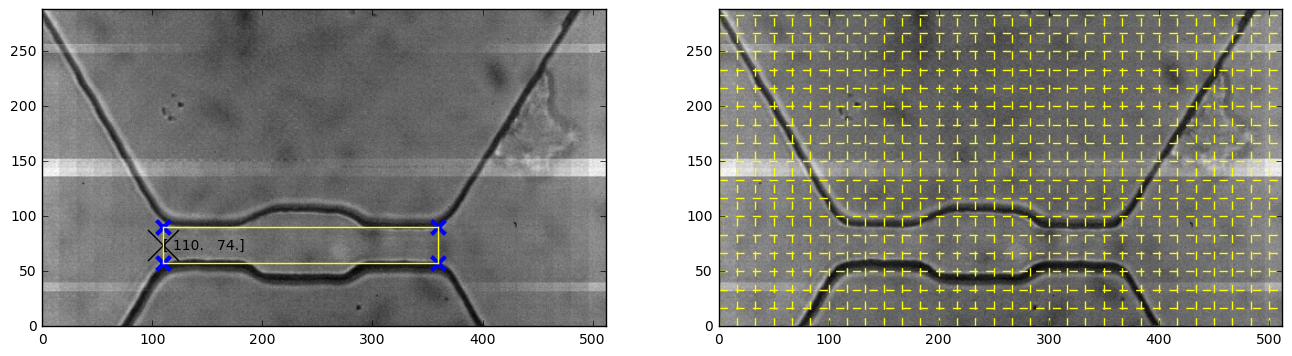

In [9]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [110,90]
c1 = [110,58]
c2 = [360,58]
c3 = [360,90]


oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Load ellipses

In [10]:
ellipsess_file_path = '../data/' + date + particle + channel + 'ellipses_' + file_index

# Load ellipsess from text file
ellipsess = []
with open(ellipsess_file_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        row = next(file_reader)
        
    while row:
        row = next(file_reader)     
        
        if row[0] == 'event #':
            ellipsess.append([])

        else:
            ellipsess[-1].append(row)

StopIteration: 

### Calculate aspect ratios

In [11]:
xcss = []
aspectss = []
for ellipses in ellipsess:
    
    
    xcss.append([])
    aspectss.append([])
    for ellipse in ellipses:
                
        x = float(ellipse[1])
        y = float(ellipse[2])
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)/oi_stage._length_microns
        
        xcss[-1].append(xc)
        
        aspect_ratio = float(ellipse[3])/float(ellipse[4])
        aspectss[-1].append(aspect_ratio)
        
    # Convert to numpy array
    xcss[-1] = np.array(xcss[-1])
    aspectss[-1] = np.array(aspectss[-1])

### Find maximum and minimum aspect ratios

In [12]:
def find_max_min_aspects(xcs, aspects, debug = False):
    
    x0 = -0.2
    x1 = 0.8
    
    xcs_temp = np.copy(xcs)[np.logical_and((xcs > x0), (xcs < x1))]
    aspects_temp = np.copy(aspects)[np.logical_and((xcs > x0), (xcs < x1))]
    
    # Smooth the aspect ratio signal
    sigma = 2
    aspects_smoothed = scipy.ndimage.filters.gaussian_filter(aspects_temp, sigma = sigma)

    # Find minima and maxima in the aspect ratios
    maxima, minima = rp.get_maxima_minima(aspects_temp, num_maxima = 1, num_minima = 1, sigma = sigma, return_by = ['high', 'low'])

    if len(maxima) > 0:
        maxima = maxima[0]
    else:
        maxima = 1
    if len(minima) > 0:
        minima = minima[0]
    else:
        minima = 1


    # Average in a window around the local minima and maxima
    window_size = 3
    max_aspect = np.mean(aspects_temp[maxima-window_size/2:maxima+window_size/2+1])
    min_aspect = np.mean(aspects_temp[minima-window_size/2:minima+window_size/2+1])






    if debug:
        # Create plot

        # Plot aspects, smoothed aspects
        plt.plot(xcs_temp, aspects_temp, lw = 3, c = 'k')
        plt.plot(xcs_temp, aspects_smoothed, c = 'gray', ls = '--', lw = 5)


        # Plot the minima/maxima as detected in the smoothed signal
        plt.scatter(xcs_temp[maxima], aspects_smoothed[maxima], s = 150, marker = 'x', lw = 5, color = 'red')
        plt.scatter(xcs_temp[minima], aspects_smoothed[minima], s = 150, marker = 'x', lw = 5, color = 'red')

        # Plot the averaged minima/maxima
        plt.plot([xcs_temp[0], xcs_temp[-1]], [max_aspect, max_aspect], ls = '--', lw = 3, c = 'red')
        plt.plot([xcs_temp[0], xcs_temp[-1]], [min_aspect, min_aspect], ls = '--', lw = 3, c = 'red')
        plt.plot([xcs_temp[0], xcs_temp[-1]], [1,1], ls = '--', lw = 3, c = 'k')

        #plt.xlim(np.min(xcs), np.max(xcs))
        plt.xlim(x0, x1)
        plt.ylim(.8,1.2)

        # Cosmetics
        plt.xlabel(r'axial position $x_{c}/L_{c}$', size = 12)
        plt.ylabel(r'aspect ratio (>1 = oblate)', size = 12)
        plt.grid()






        plt.show()
        
    return max_aspect, min_aspect

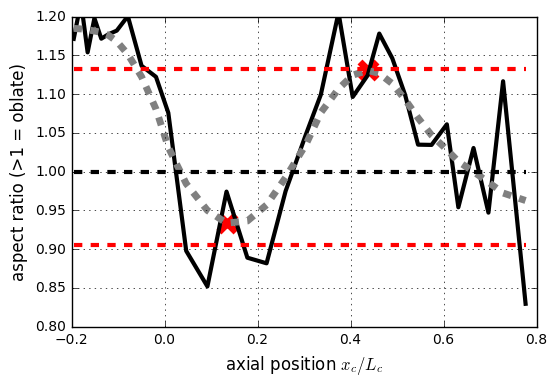

(1.1327683175445911, 0.90483971665094565)

In [13]:
index = 7

find_max_min_aspects(xcss[index], aspectss[index], debug = True)

### Calculate minimum and maximum aspect for all events

0


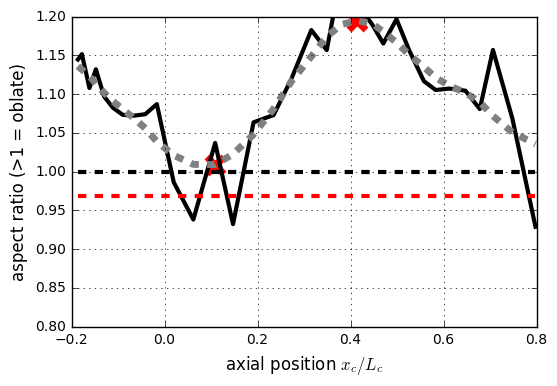

1


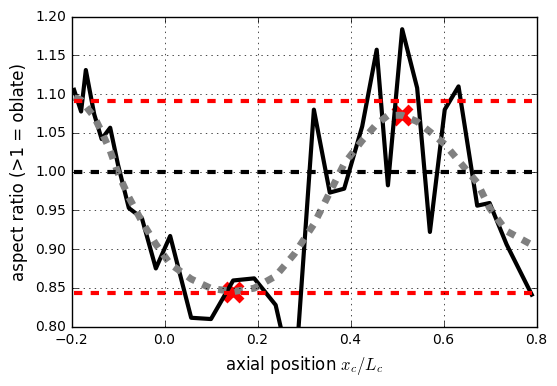

2


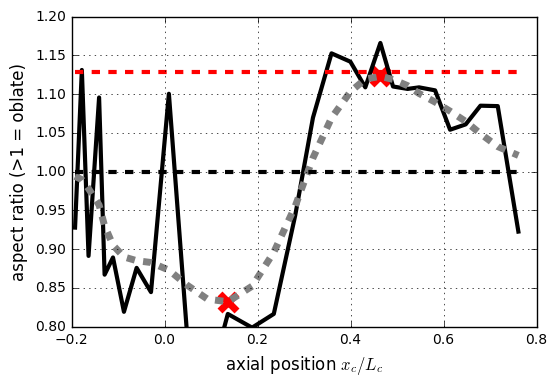

3


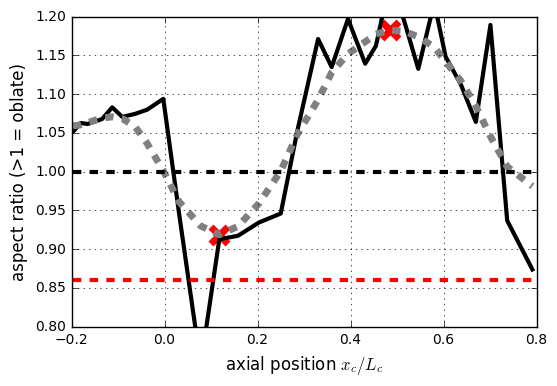

4


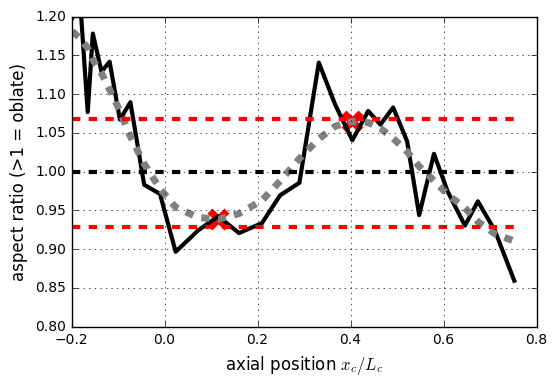

5


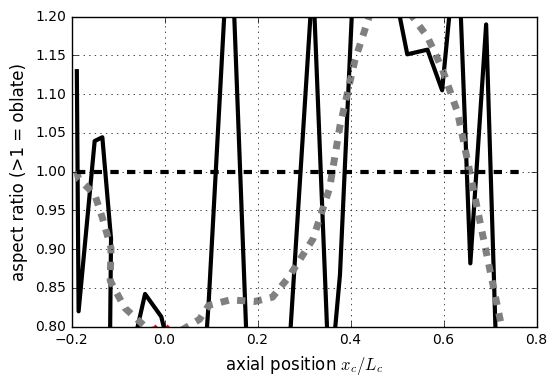

6


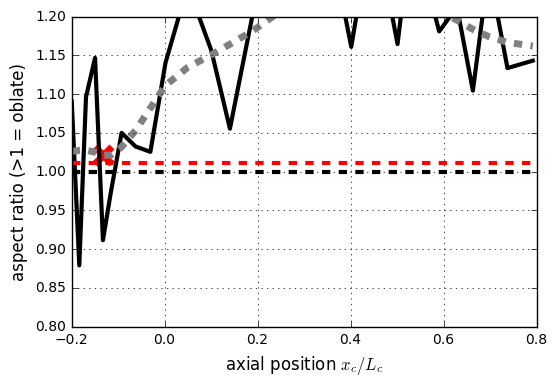

7


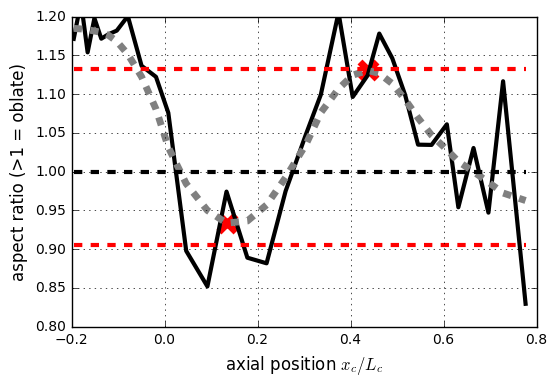

8


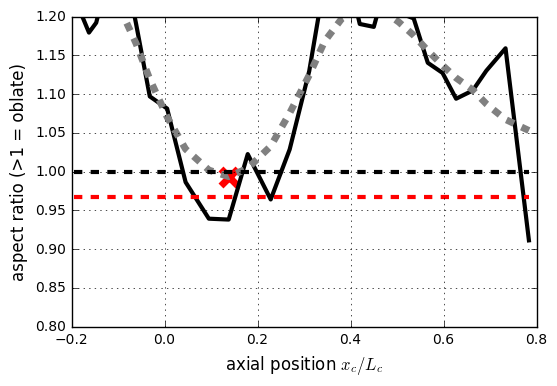

9


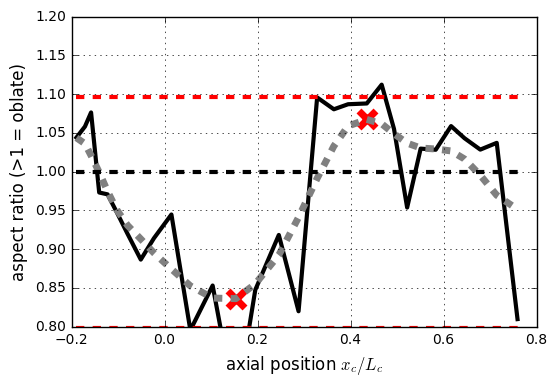

10


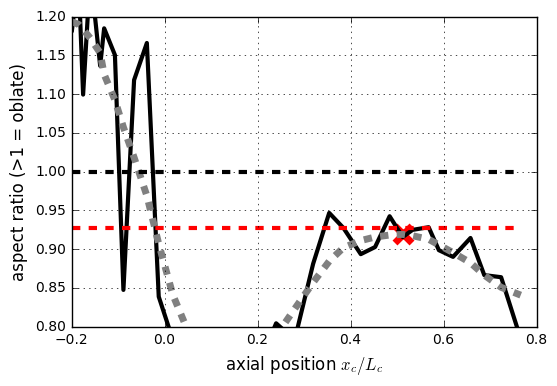

11


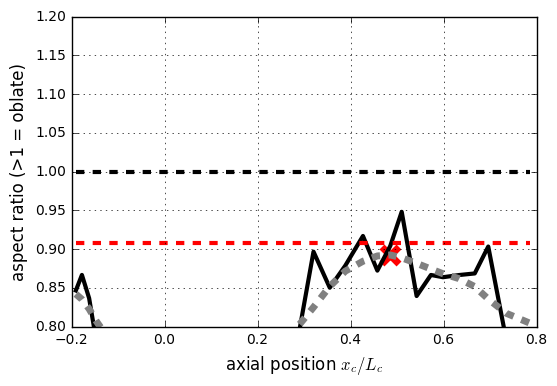

12


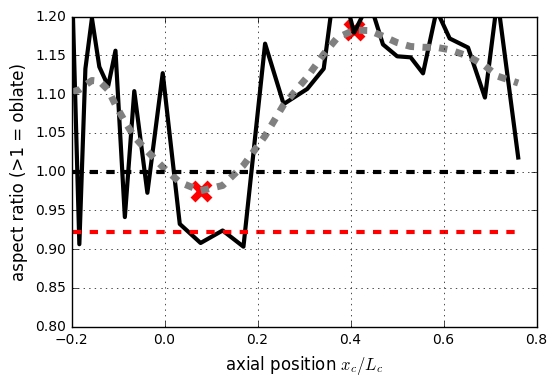

13


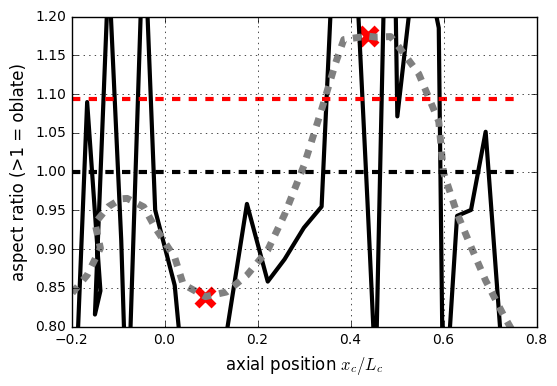

14


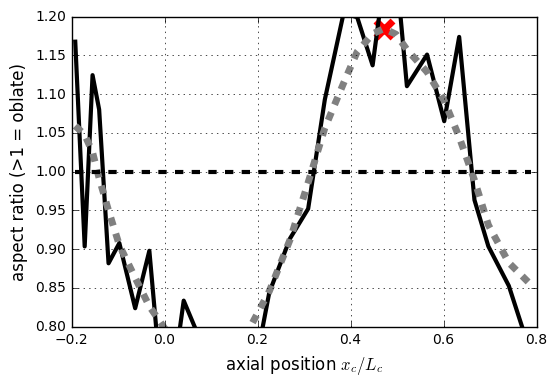

15


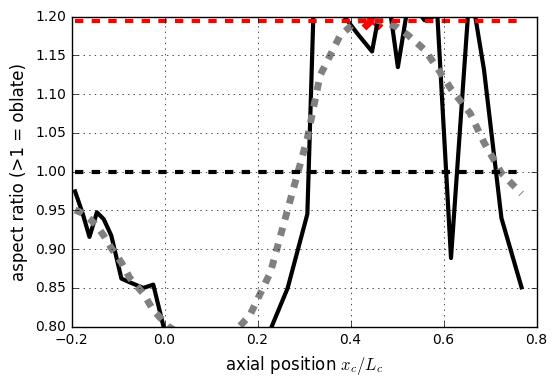

16


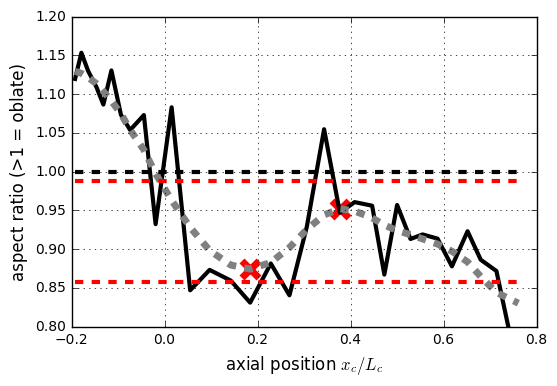

17


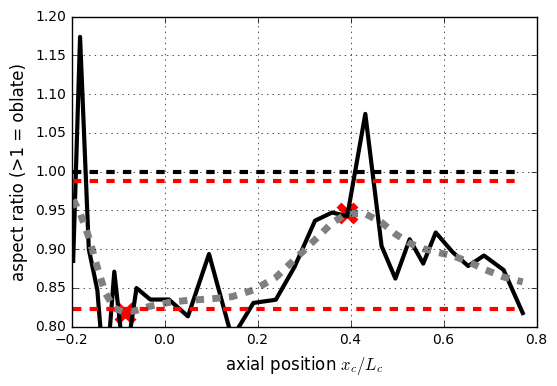

18


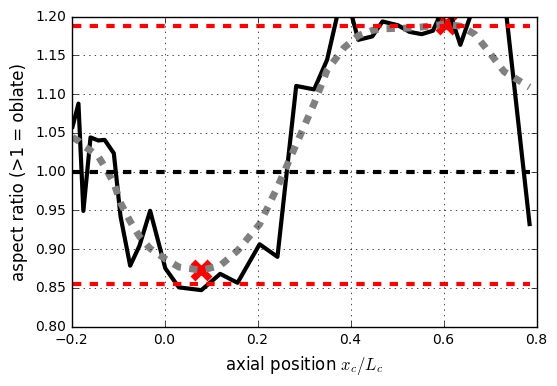

19


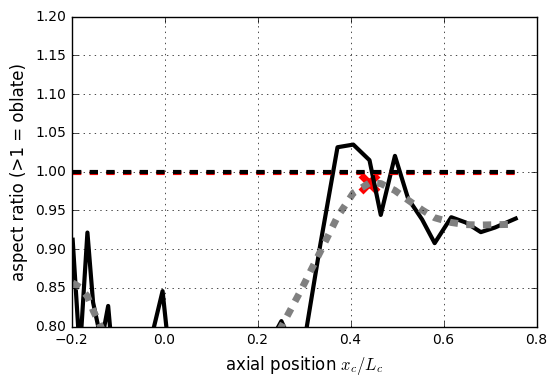

20


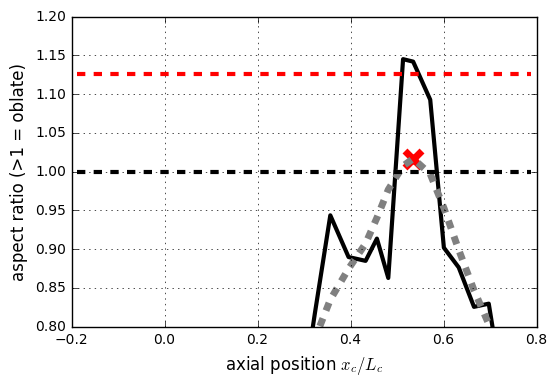

21


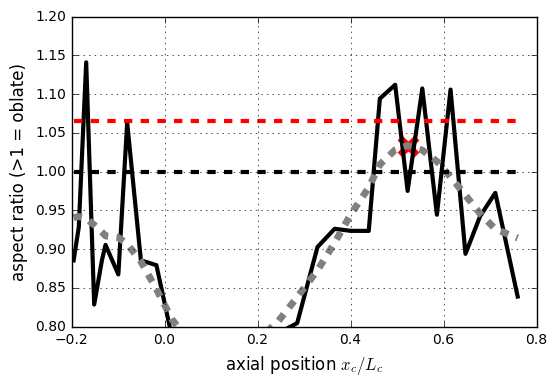

22


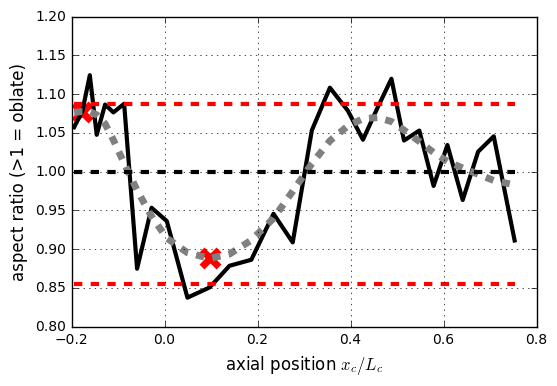

23


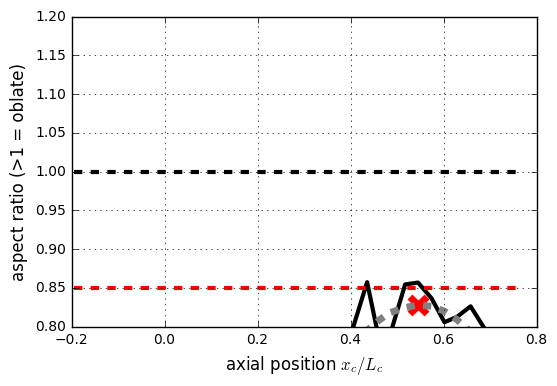

24


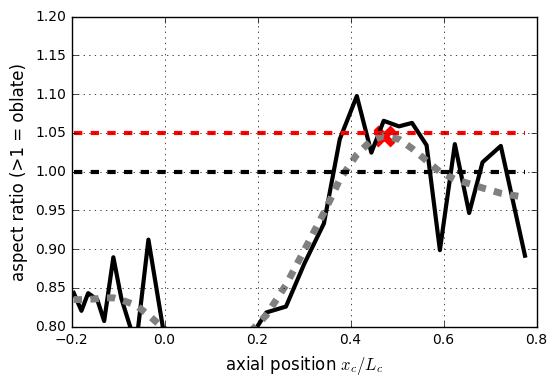

25


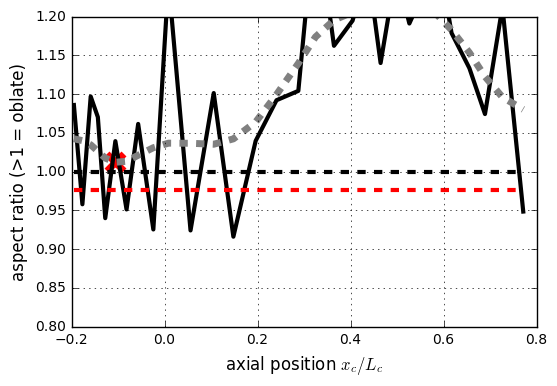

26


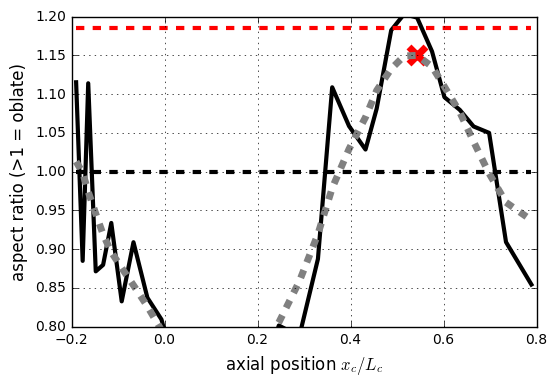

27


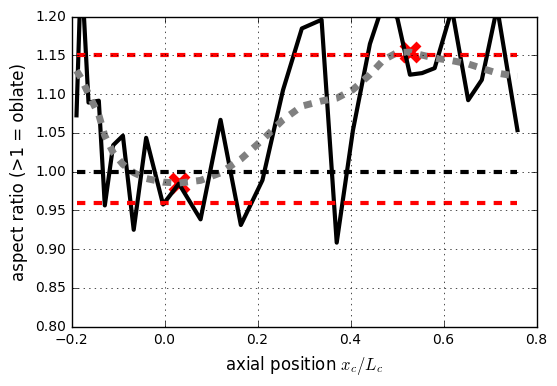

28


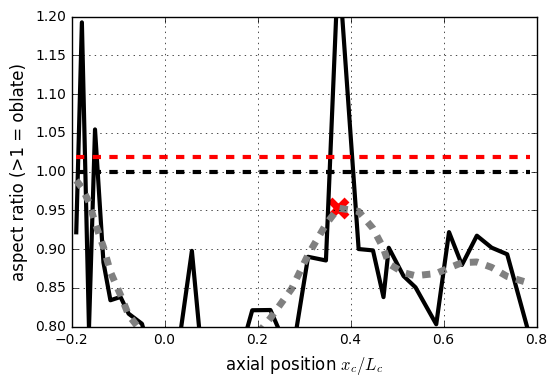

29


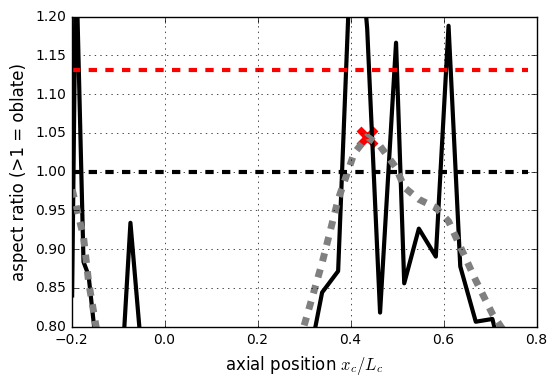

30


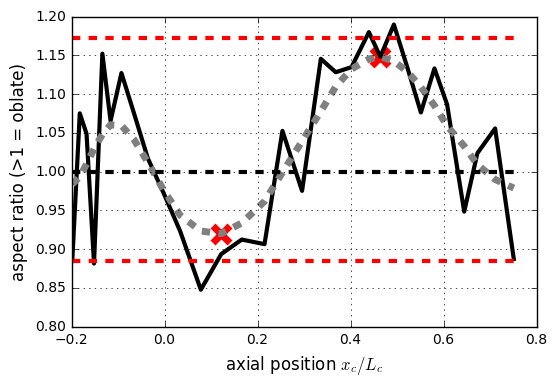

31


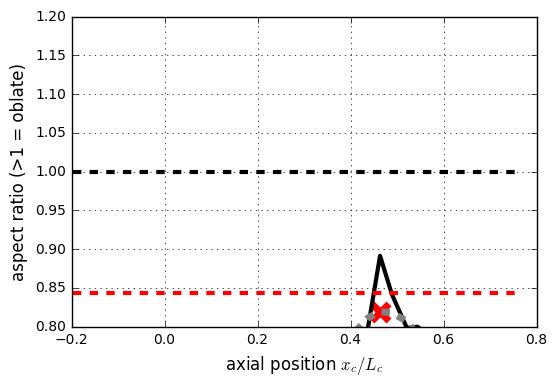

32


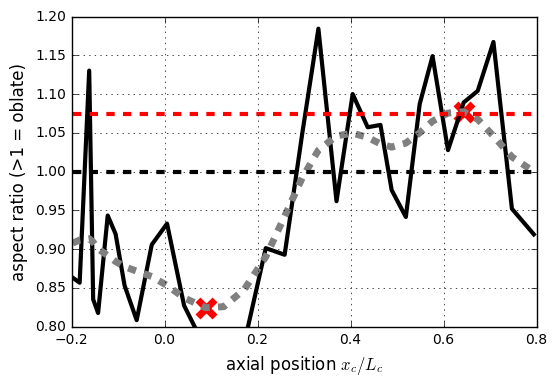

33


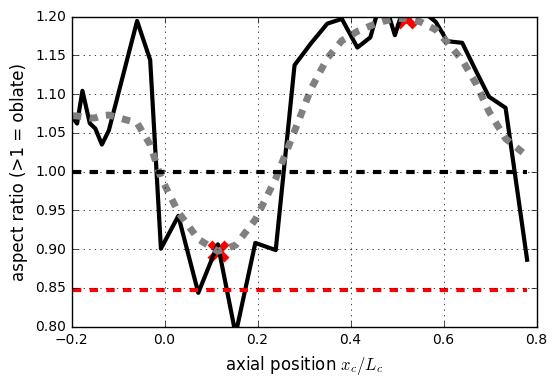

34


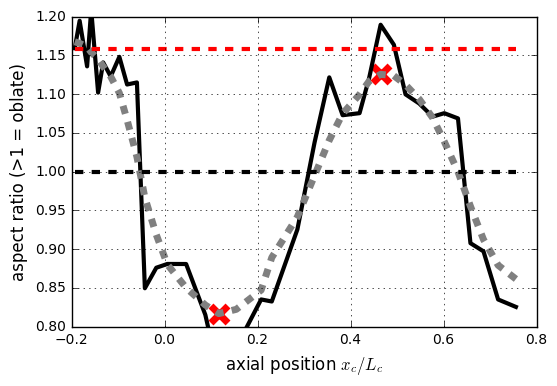

35


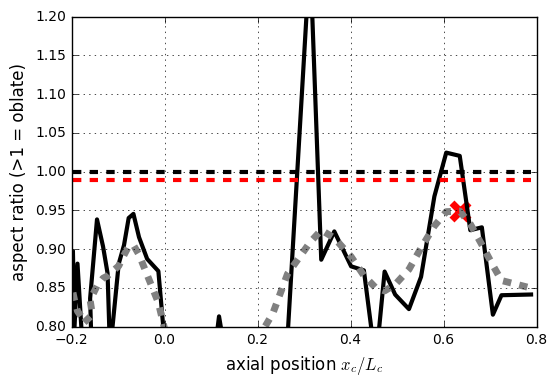

36


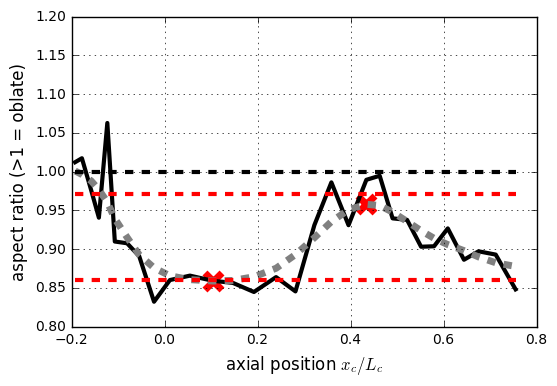

37


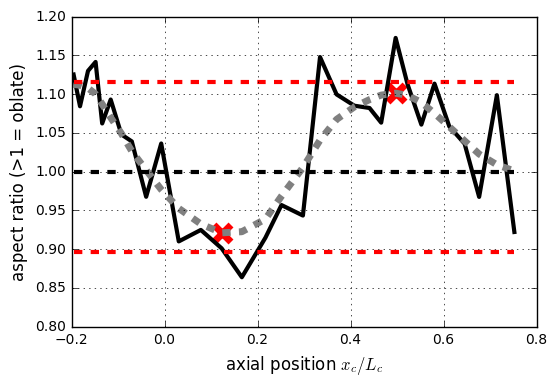

38


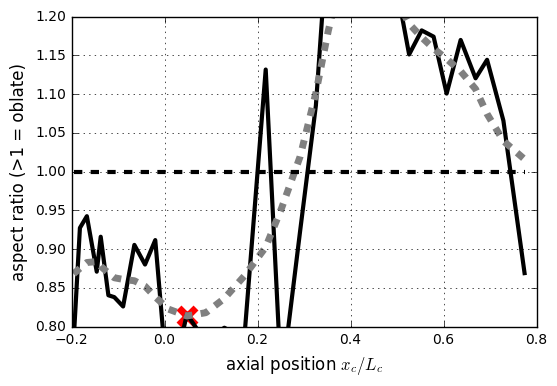

39


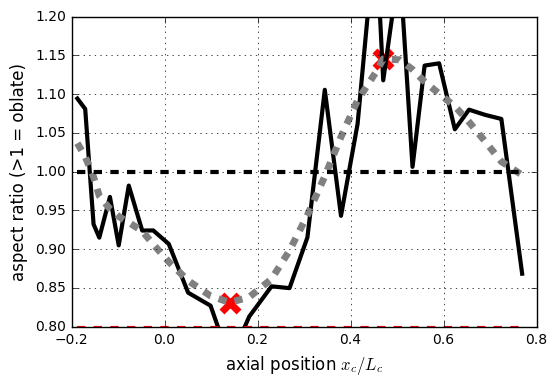

40


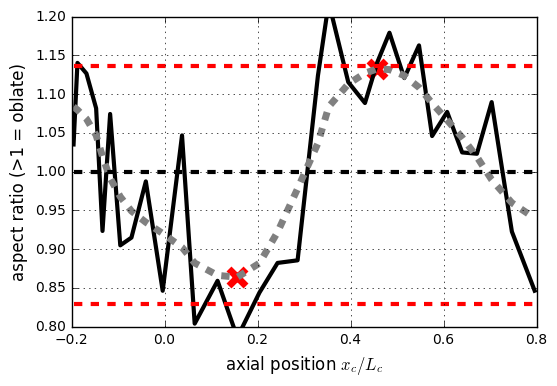

41


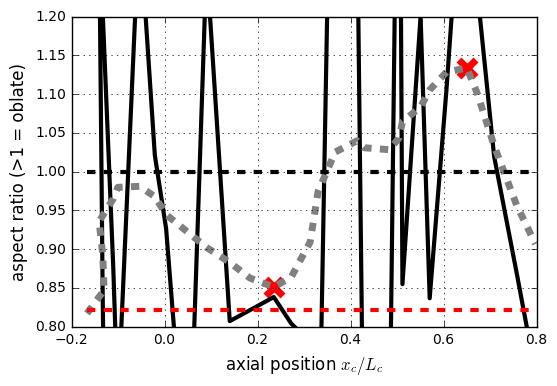

42


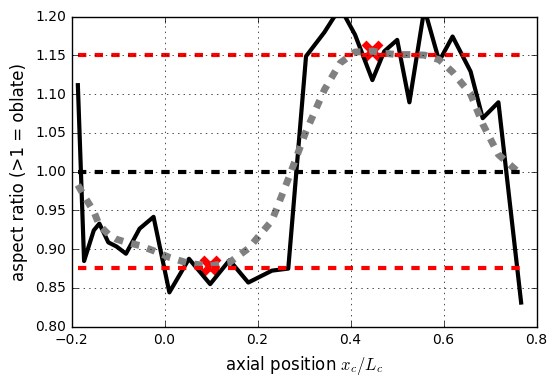

43


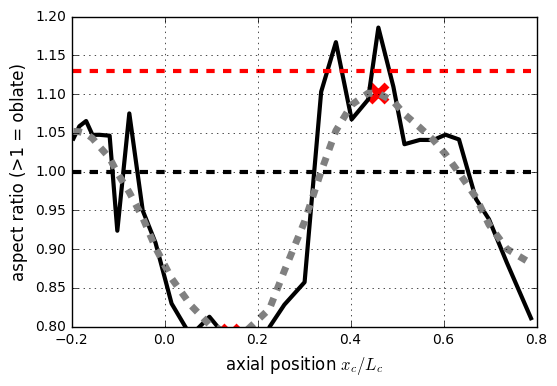

In [14]:
max_aspects = []
min_aspects = []

for i in range(len(aspectss)):
    
    print i
    xcs = xcss[i]
    aspects = aspectss[i]
    
    max_aspect, min_aspect = find_max_min_aspects(xcs, aspectss[i], debug = True)
    
    max_aspects.append(max_aspect)
    min_aspects.append(min_aspect)
    

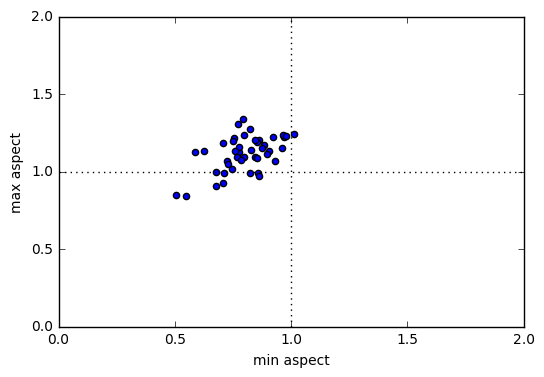

In [15]:
plt.scatter(min_aspects, max_aspects)

plt.plot([0,10],[1,1], c = 'k', ls = ':')
plt.plot([1,1],[0,10], c = 'k', ls = ':')

plt.xlabel('min aspect')
plt.ylabel('max aspect')

plt.xlim(0,2)
plt.ylim(0,2)

plt.show()

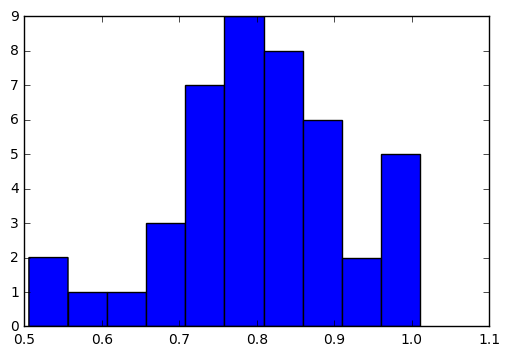

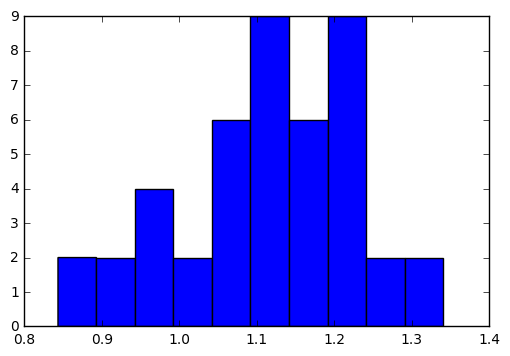

In [16]:
plt.hist(min_aspects)
plt.show()

plt.hist(max_aspects)
plt.show()

# Save data and parameters

### Save all aspect info

In [17]:
output_file_path = '../data/' + date + particle + channel + 'aspects_' + file_index
print output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write header
    file_writer.writerow([date + particle + channel + file_index])
    
    # Write data
    for i in range(len(aspectss)):
        file_writer.writerow(['event #', i])
        for j in range(len(xcss[i])):
            file_writer.writerow([xcss[i][j], aspectss[i][j]])

../data/7-17-2017/293-T/15-30-15_1/aspects_0


### Save max min aspects

In [18]:
output_file_path = '../data/' + date + particle + channel + 'max-min_aspects_' + file_index
print output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write header
    file_writer.writerow([date + particle + channel + file_index])
    
    # Write data
    for i in range(len(aspectss)):
        file_writer.writerow(['event #', i])
        file_writer.writerow([max_aspects[i], min_aspects[i]])

../data/7-17-2017/293-T/15-30-15_1/max-min_aspects_0
